<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/distilBERT2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [3]:
from transformers import PreTrainedTokenizerFast, TFAutoModel
import datasets

# gptModel = 'raygx/GPT-NepSA-T2' ## Fine-tuned Model ## 'raygx/Nepali-GPT2-CausalLM' ## Pre-Trained LM ##
# gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
# gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'raygx/distilBERT-Nepali' ## Pre-Trained LM ##
bertTokenizer = PreTrainedTokenizerFast.from_pretrained(bertModel)
bertModel = TFAutoModel.from_pretrained(bertModel)
bertModel.config

Some layers from the model checkpoint at raygx/distilBERT-Nepali were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at raygx/distilBERT-Nepali.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


DistilBertConfig {
  "_name_or_path": "raygx/distilBERT-Nepali",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "dim": 768,
  "dropout": 0.1,
  "eos_token_id": 2,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 2,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 50000
}

In [4]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [5]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [6]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [21]:
import tensorflow as tf

# class GPTEmbedding(tf.keras.layers.Layer):
#   def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
#     super().__init__()
#     self.embedding = model
#     self.tokenizer = tokenizer
#     self.tokenizer.padding_side = 'left'
#     self.max_token = max_token_len
#     self.padding = padding
#     self.truncation = truncation
#     self.trailing_context = trailing_context
#     self.trainable=False

#   def call(self, x):
#     embeddings = self.embedding(
#                   self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
#                 )[0][:,-self.trailing_context:,:]

#     return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    x = self.embedding(
          self.tokenizer(
                x,
                padding=self.padding,
                truncation=self.truncation,
                max_length=self.max_token,
                return_tensors='tf'
              )
        )[0][:,:1,:]

    return tf.reshape(x,(x.shape[0],x.shape[-1]))

### Preparing Training Data

In [24]:
from tqdm.auto import tqdm

# gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=4,max_token_len=100)
bertEmbd = BERTEmbedding(model=bertModel,tokenizer=bertTokenizer,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = bertEmbd(data['train'][i:i+batch]['text'])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 768)

In [25]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [26]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 9min 18s, sys: 1.14 s, total: 9min 19s
Wall time: 9min 21s


array([0, 1, 2])

### Preparing Test Data

In [27]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = bertEmbd(data['test'][i:i+batch]['text'])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

## Evaluation

In [28]:
%%time
predictions = clf.predict(testX)

CPU times: user 2min 38s, sys: 270 ms, total: 2min 38s
Wall time: 2min 39s


In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.7252241081661882
Precision-Score 0.7391842411181229
Recall-Score 0.7243952340835239
accuracy_Score 0.7243952340835239


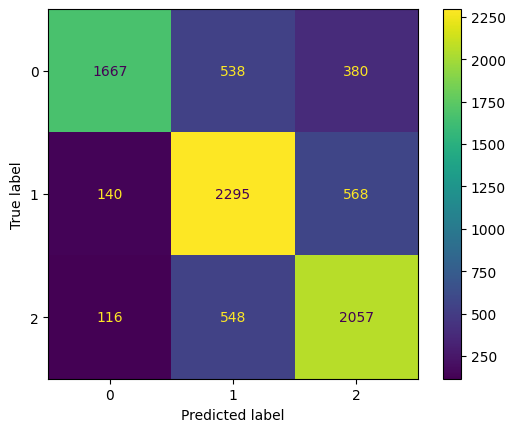

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()